In this notebook we test FFNN for Honeycomb Heisenberg model

Honeycomb 3x3 has 18 spins and is numerically solvable. We test for 3x3 and then try to approximate for 5x5 honeycomb, which has 50 spins

In [29]:
import netket as nk
import jax.numpy as jnp
import numpy as np
import json
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
from Hamiltonians import Heisenberg
from Models import FeedForwardNeuralNetwork
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
read = False
res_path = Path('./Simulations/5-FFNNComparison')
image_path = Path('./images/5-FFNNComparison')
extent = [3, 3]
alpha_list = [(0.3,), (1,), (2,), (1, 1), (2, 2)]#, (2, 4, 2)] too much time on my cpu
Sz = 0
lr = 0.05
ds = 0.1
n_iter = 1000
n_samples = 800
ffnn_results0 = []
times = []

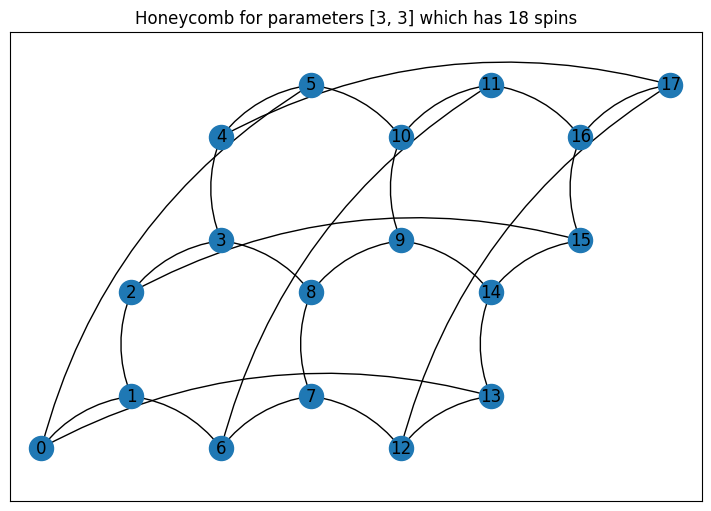

In [3]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [4]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
eval_gs = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=False)[0]
eval_gs

-40.38866334601949

Comparing different Feed Forward Neural Networks

In [5]:
for alpha in alpha_list:
    honey_path = f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}' \
                 f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'
    if not read:
        honey = nk.graph.Honeycomb(extent=extent, pbc=True)
        hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
        hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
        sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
        optimizer = nk.optimizer.Sgd(learning_rate=lr)
        sr = nk.optimizer.SR(diag_shift=ds)
        ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha)
        vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
        gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                    preconditioner=sr, variational_state=vstate)
    
        start = time()
        gs.run(n_iter=n_iter, out=honey_path)
        print(f'Time: {(t := time()-start):.3f} seconds')
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_result = json.load(res)
        ffnn_result['time'] = t
        if eval_gs is not None:
            ffnn_result['gs'] = float(eval_gs)
        with open(f'{honey_path}.log', 'w') as f:
            json.dump(ffnn_result, f)
        ffnn_results0.append(ffnn_result)
    else:
        with open(f'{honey_path}.log') as res:
            ffnn_results0.append(json.load(f))

  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 24.331 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 39.806 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 64.551 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 66.914 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 172.289 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 645.913 seconds


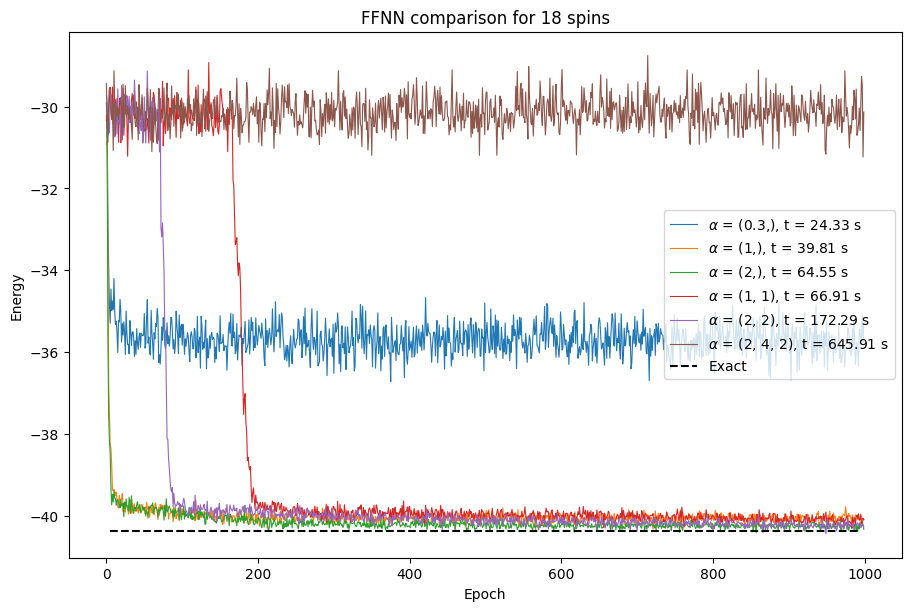

In [6]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for ffnn_res, alpha in zip(ffnn_results0, alpha_list):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'], linewidth=0.8,
              label=f'$\\alpha$ = {alpha}, t = {ffnn_res["time"]:.2f} s')
if eval_gs is not None:
    axes.axhline(y=eval_gs, xmin=0.05, xmax=0.95, 
                 color='black', linestyle='--', label='Exact')
axes.set(xlabel='Epoch', ylabel='Energy', 
         title=f'FFNN comparison for {honey.n_nodes} spins')
axes.legend()
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

Testing again for 50 spins and 1000 epochs

In [7]:
read = False
extent = [5, 5]
eval_gs = None
lr = 0.05
ds = 0.1
n_iter = 5000
n_samples = 800
ffnn_results1 = []

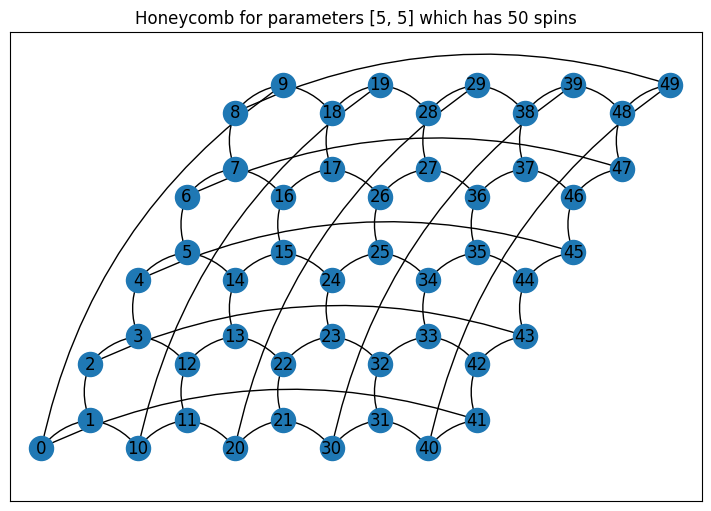

In [8]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [9]:
for alpha in alpha_list:
    honey_path = f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}' \
                 f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'
    if not read:
        honey = nk.graph.Honeycomb(extent=extent, pbc=True)
        hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
        hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
        sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
        optimizer = nk.optimizer.Sgd(learning_rate=lr)
        sr = nk.optimizer.SR(diag_shift=ds)
        ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha, param_dtype=jnp.float32)
        vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
        gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                    preconditioner=sr, variational_state=vstate)
    
        start = time()
        gs.run(n_iter=n_iter, out=honey_path)
        print(f'Time: {(t := time()-start):.3f} seconds')
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_result = json.load(res)
        ffnn_result['time'] = t
        if eval_gs is not None:
            ffnn_result['gs'] = float(eval_gs)
        with open(f'{honey_path}.log', 'w') as f:
            json.dump(ffnn_result, f)
        ffnn_results1.append(ffnn_result)
    else:
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_results1.append(json.load(res))

  0%|          | 0/5000 [00:00<?, ?it/s]

Time: 913.300 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

Time: 2224.199 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

Time: 4185.002 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

Time: 4257.437 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

Time: 14190.578 seconds


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

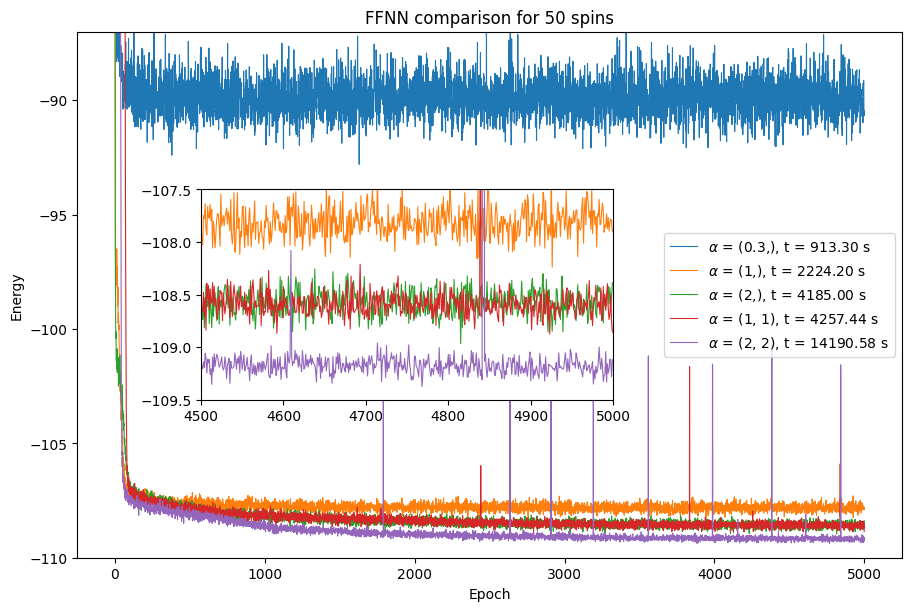

In [39]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
inset_ax = axes.inset_axes([0.15, 0.3, 0.5, 0.4])
for ffnn_res, alpha in zip(ffnn_results1, alpha_list):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'], linewidth=0.8,
              label=f'$\\alpha$ = {alpha}, t = {ffnn_res["time"]:.2f} s')
    inset_ax.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'], linewidth=0.8)
if eval_gs is not None:
    axes.axhline(y=eval_gs, xmin=0.05, xmax=0.95, 
                 color='black', linestyle='--', label='Exact')
axes.set(xlabel='Epoch', ylabel='Energy', ylim=[-110, -87],
         title=f'FFNN comparison for {honey.n_nodes} spins')
axes.legend()
inset_ax.set(xlim=[4500, 5000], ylim=[-109.5, -107.5])
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

As we can see, the best performance isn't straightforward. For smaller number of spins the best performing model was $\alpha = 2$, but for 50 spins better option was two-layer model $\alpha = (1, 1)$